In [1]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load graph for localgraphclustering package

In [2]:
# Read graph. This also supports gml format.
g = graph_class_local.GraphLocal('./datasets/JohnsHopkins.edgelist','edgelist','\t')

# Load graph using graph-tool in order to extract graph attributes as well.

In [3]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

# Load coordinates for visualization

In [4]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Extract "ground truth" cluster, i.e., nodes with majorIndex 217

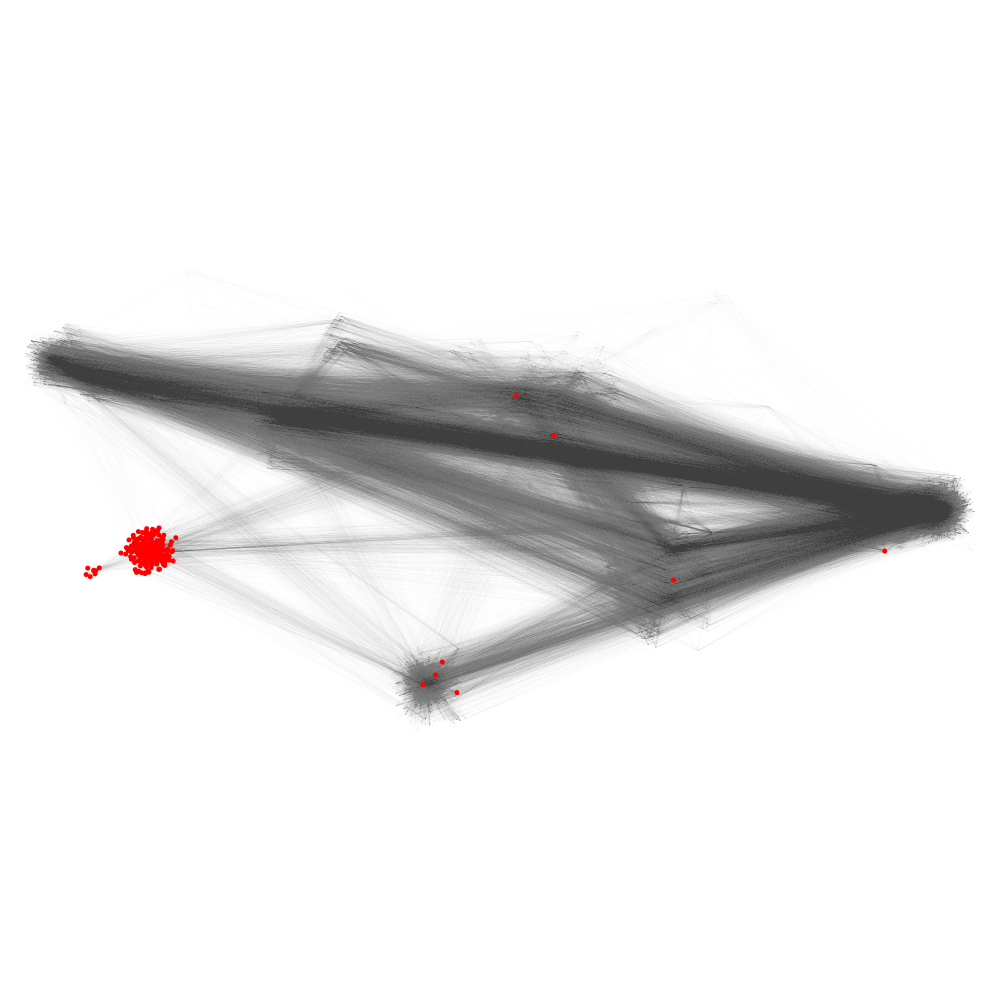

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10b5640b8, at 0x10e614eb8>

In [5]:
# For details about the "ground truth" cluster please refer to: D. Wang, K. Fountoulakis, M. Henzinger, 
# M. Mahoney and S. Rao. Capacity Releasing Diffusion for Speed and Locality. ICML 2017.

g_gtool_majorIndex = g_gtool.vertex_properties.majorIndex

majorIndex_217_students = []
for i in range(g._num_vertices):
    if g_gtool_majorIndex[i] == 217.0:
        majorIndex_217_students.append(i)
        
# Visualize students of dorm 217.
temp = np.zeros(g._num_vertices) + 0.00001

temp[majorIndex_217_students] = 5

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in majorIndex_217_students:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 1000),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

# Run flow-based algorithm Capacity Releasing Diffusion

CRD iteration:  1
precision: 1.0
recall:  0.00841357389922


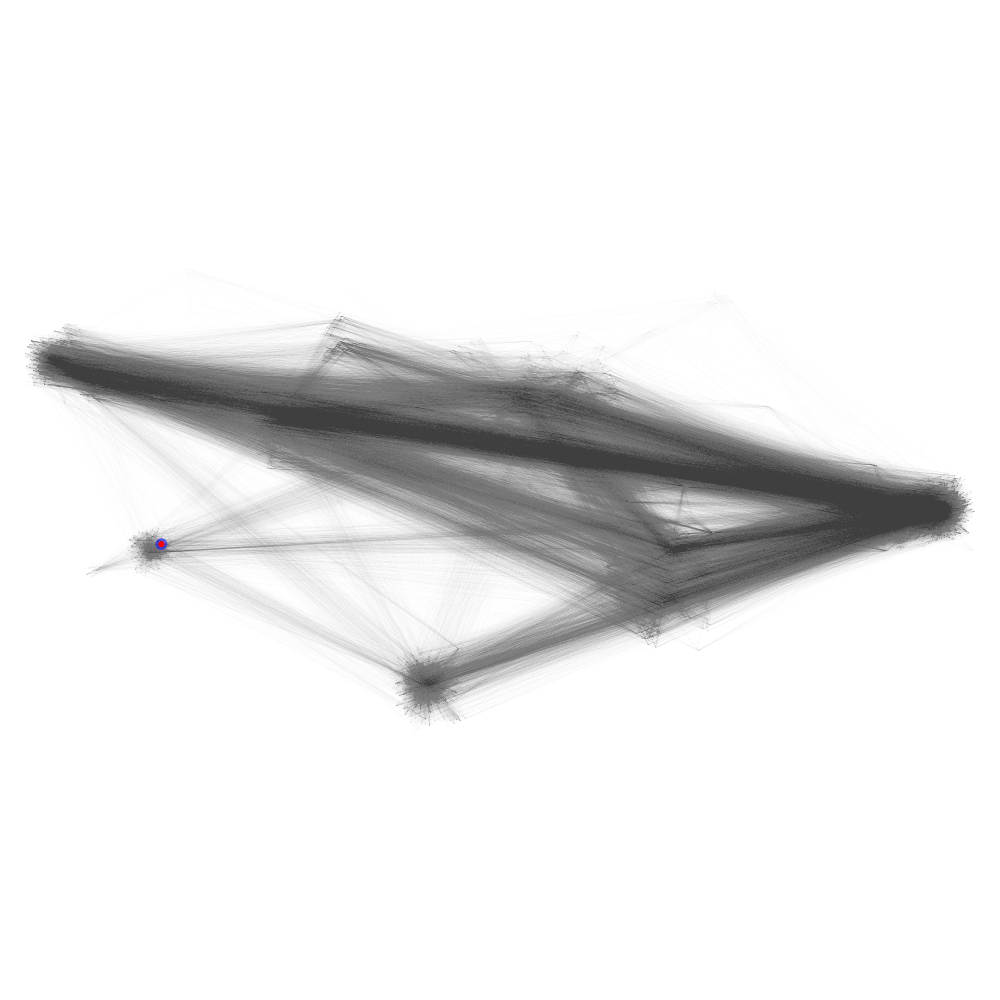

CRD iteration:  2
precision: 1.0
recall:  0.00841357389922


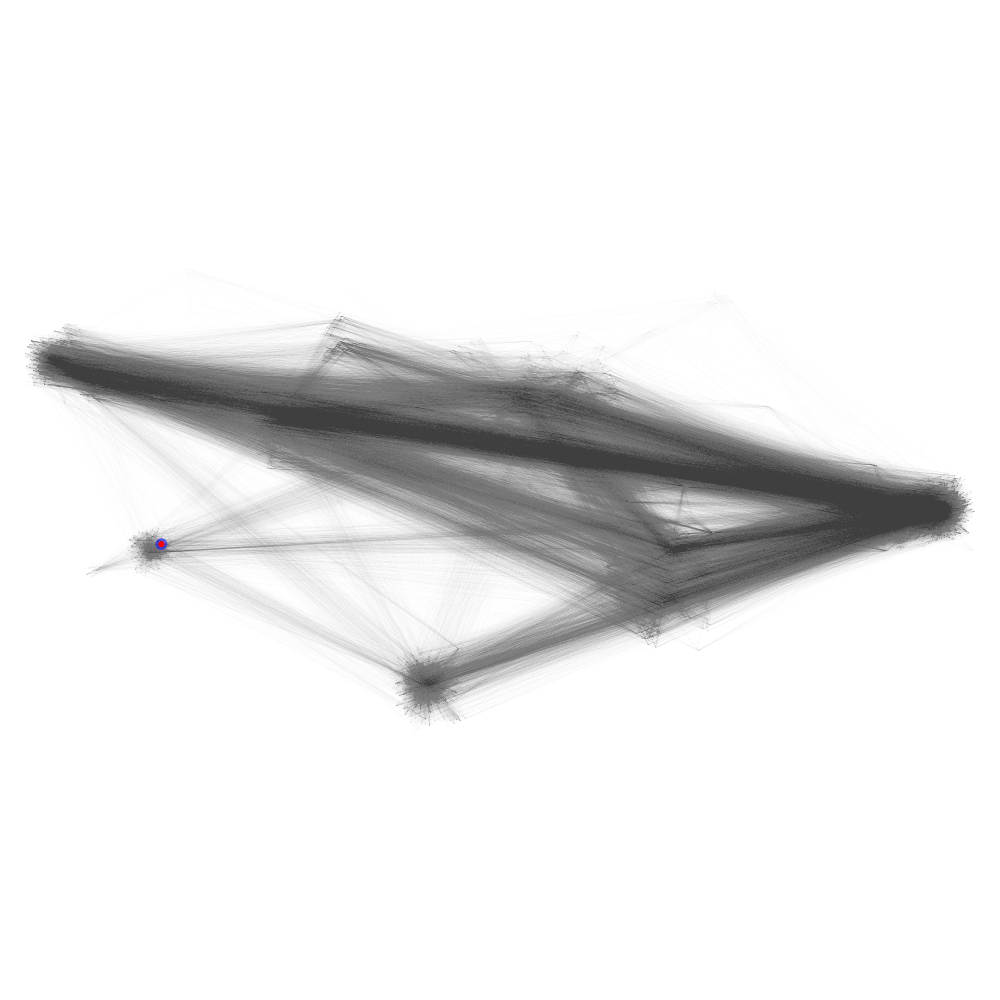

CRD iteration:  3
precision: 1.0
recall:  0.00916144713471


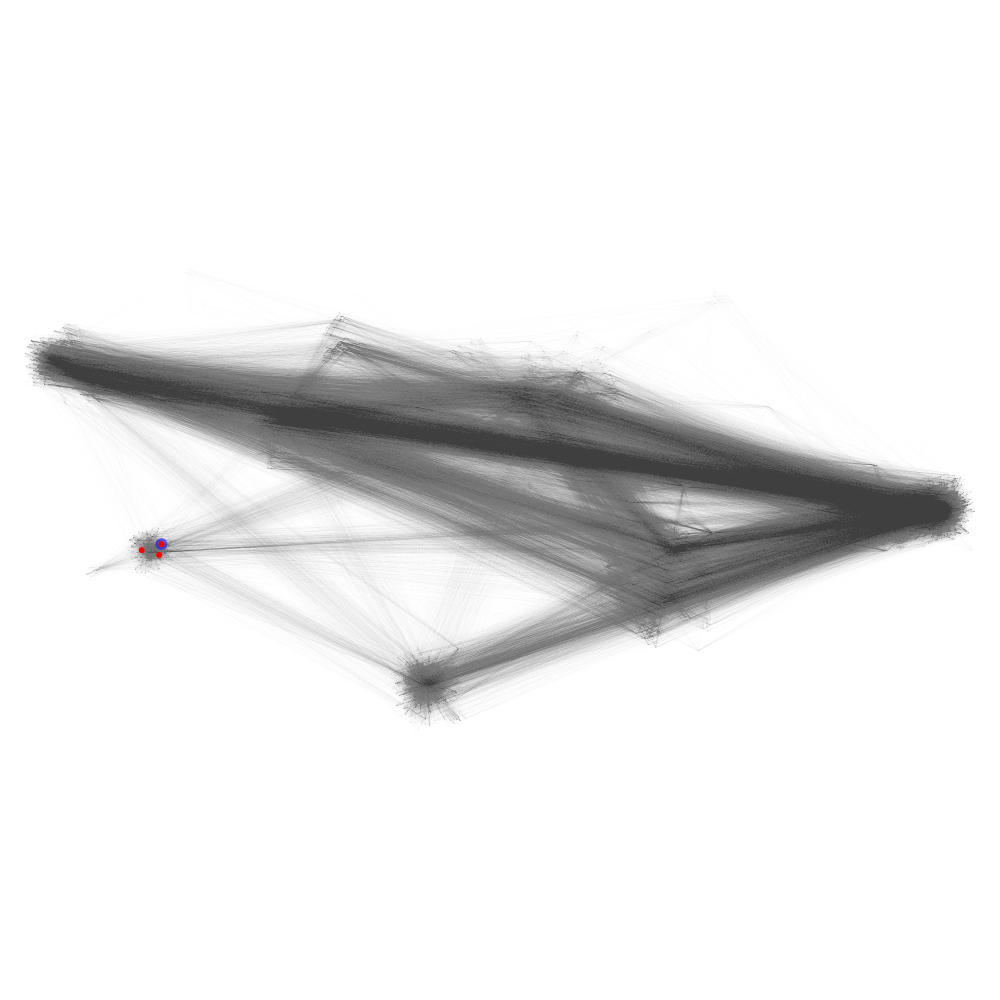

CRD iteration:  4
precision: 0.918918918919
recall:  0.0158923062541


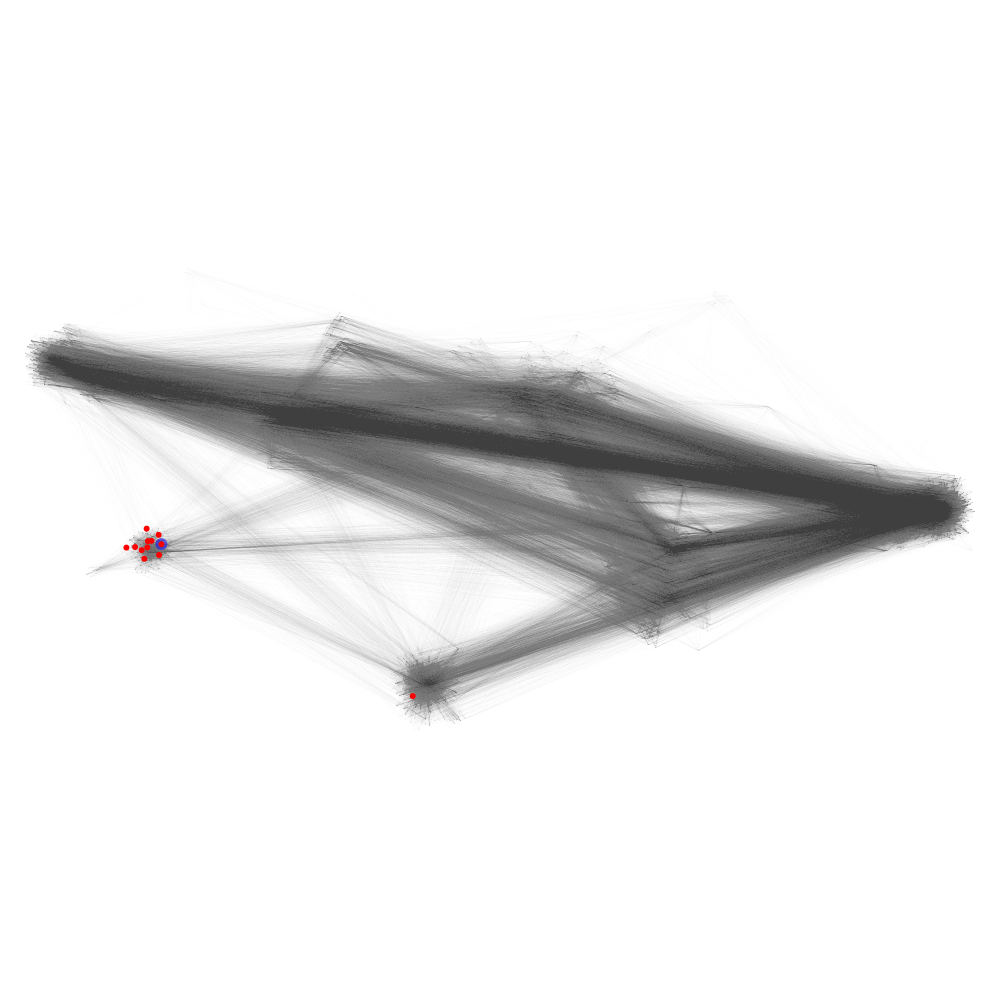

CRD iteration:  5
precision: 0.768404907975
recall:  0.0468355613723


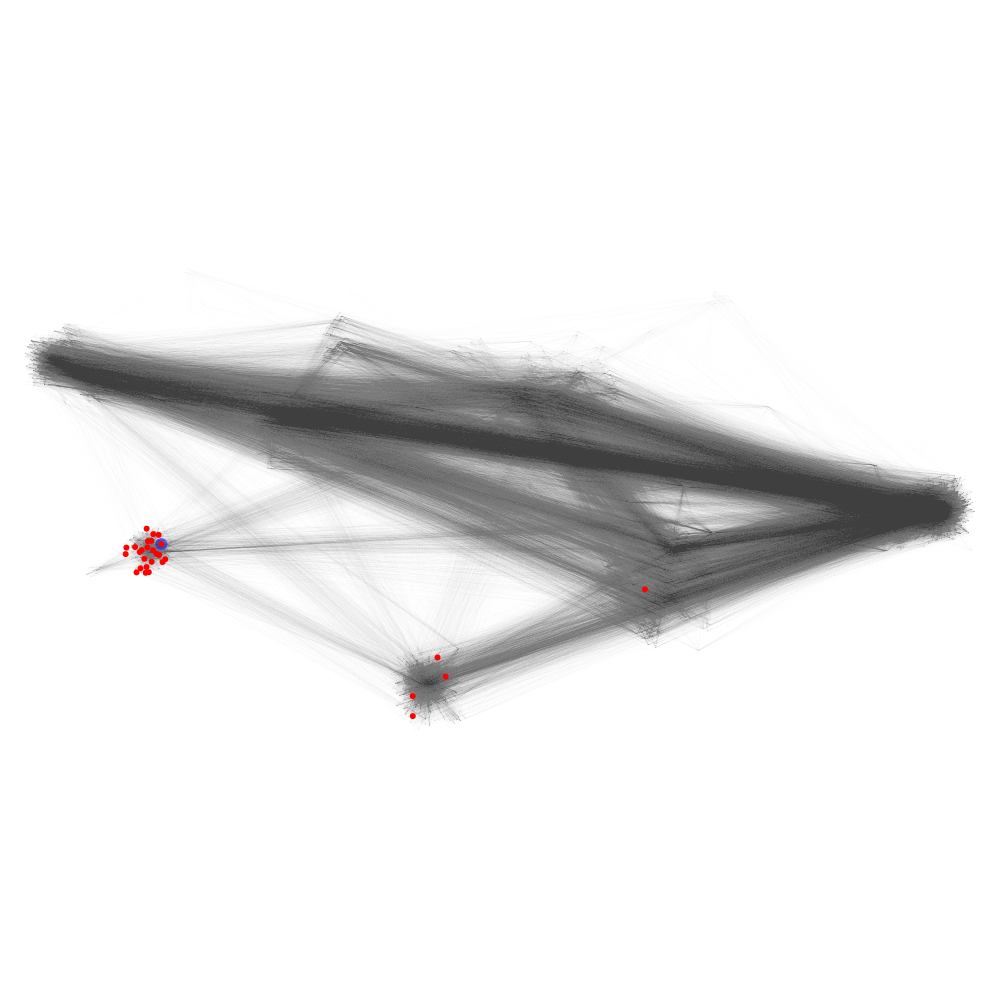

CRD iteration:  6
precision: 0.869827586207
recall:  0.0943255118257


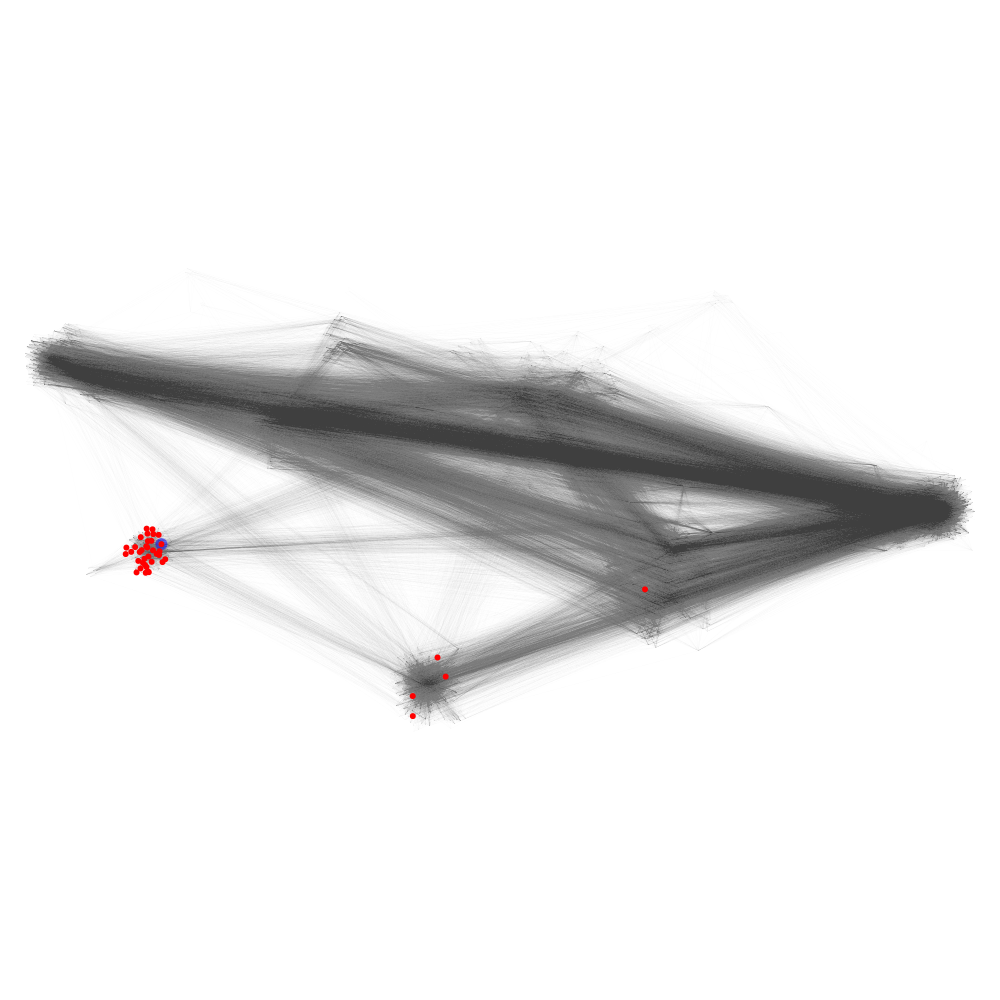

CRD iteration:  7
precision: 0.851652432232
recall:  0.428811816397


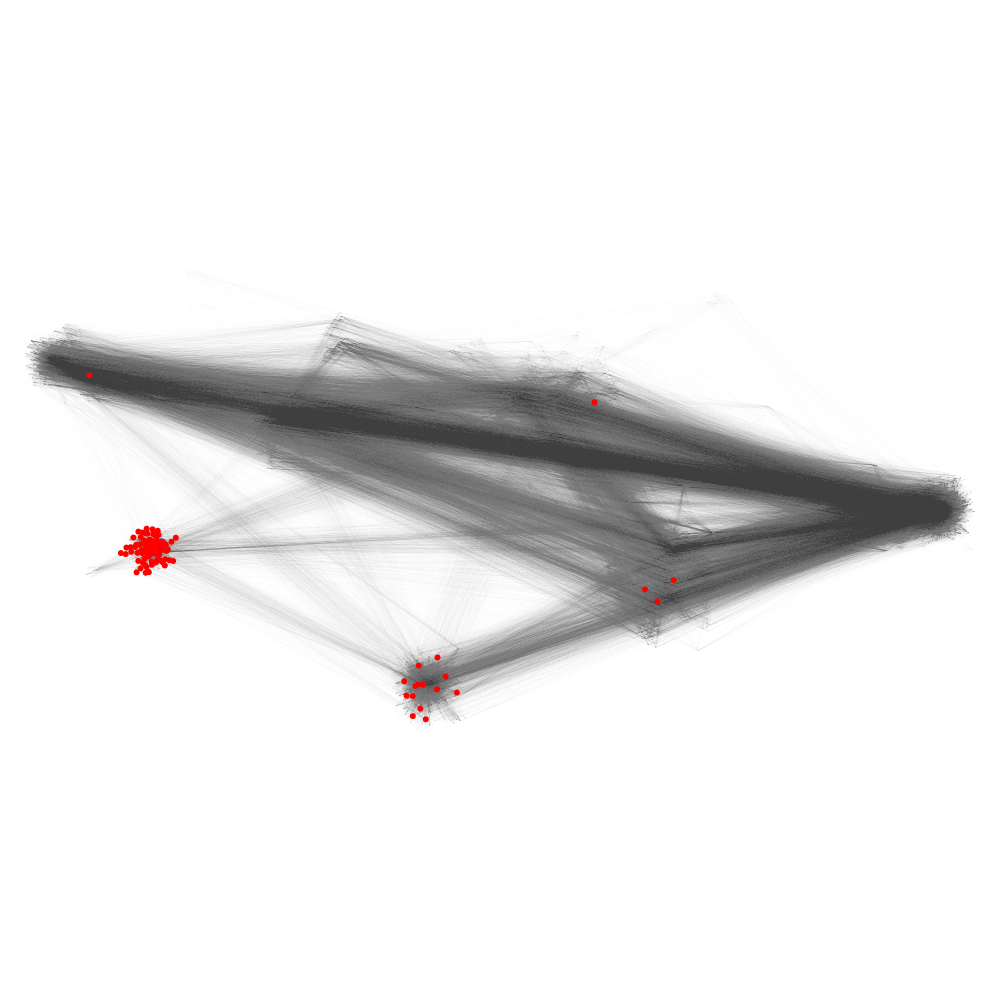

CRD iteration:  8
precision: 0.891688447465
recall:  0.797326353183


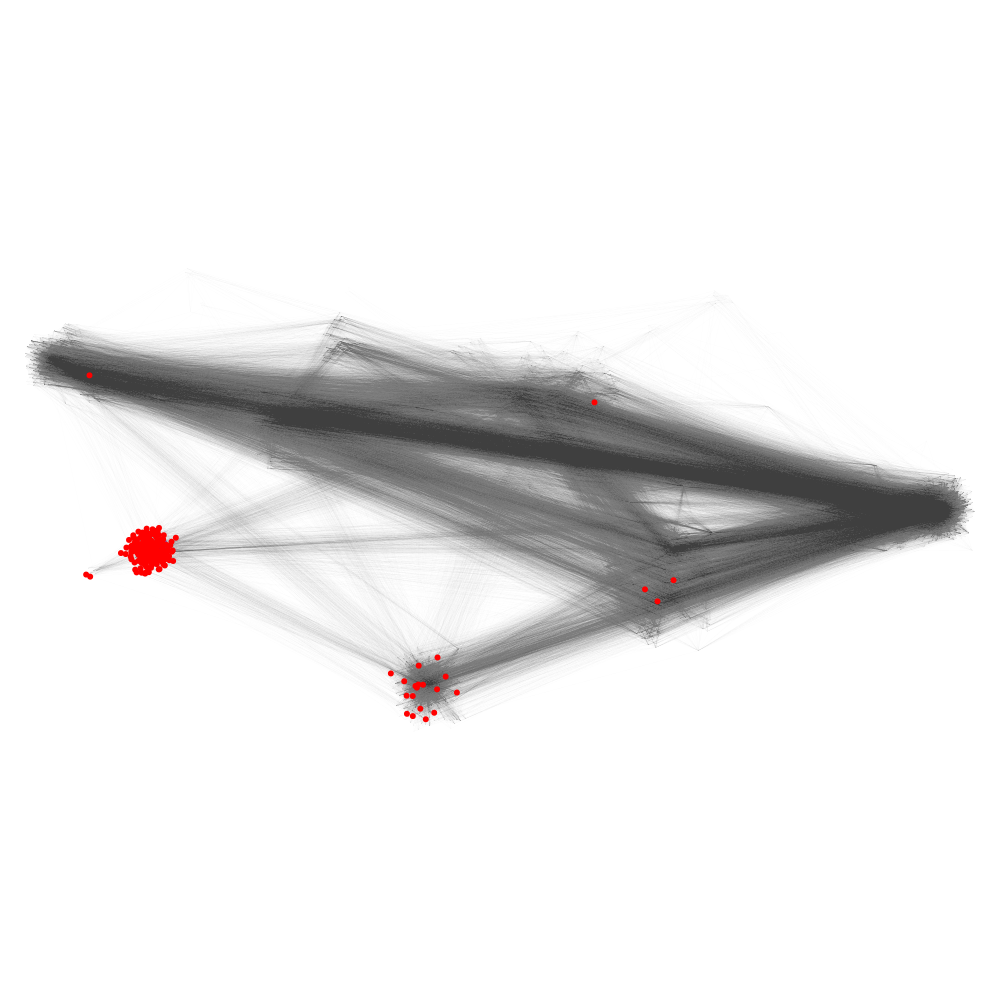

CRD iteration:  9
precision: 0.872708494707
recall:  0.947929325979


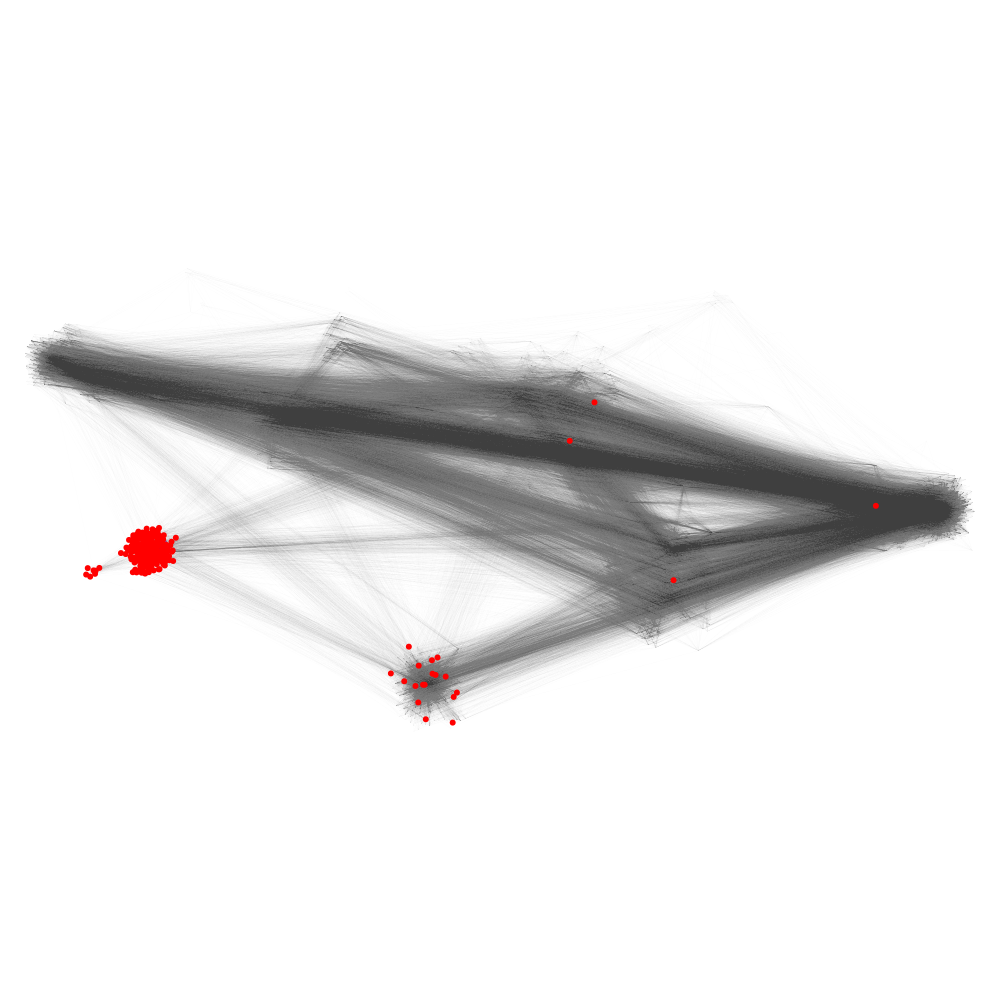

In [ ]:
ref_node = [3950]

# Create an object for the C++ version of Capacity Releasing Diffusion
crd_fast = capacity_releasing_diffusion_fast.Capacity_Releasing_Diffusion_fast()

for iterations in range(9):

    # Run the algorithm
    output_crd_fast = crd_fast.produce([g],[ref_node],iterations = iterations + 1)
    
    # Only one input graph is given, i.e., [g]. 
    # Extract the array from position 0 and store it.h.
    output_crd_fast = output_crd_fast[0]
    
    # Measure accuracy
    true_positives = set(majorIndex_217_students).intersection(output_crd_fast)
    if len(true_positives) == 0:
        true_positives = set(ref_node)
        vol = g.d[ref_node]
    else:
        vol = sum(g.d[output_crd_fast])   
    precision_ex = sum(g.d[np.array(list(true_positives))])/vol
    recall_ex = sum(g.d[np.array(list(true_positives))])/sum(g.d[majorIndex_217_students])
    print("CRD iteration: ", iterations + 1)
    print("precision:", precision_ex)
    print("recall: ", recall_ex)
    
    # Visualize the results.
    temp = np.zeros(g._num_vertices) + 0.00001

    temp[output_crd_fast] = 6

    node_size = g_gtool.new_vertex_property("double",temp)

    temp = ["black" for x in range(g._num_vertices)]

    for i in output_crd_fast:
        temp[i] = "red"

    node_colours = g_gtool.new_vertex_property("string",temp)  

    halo = np.zeros(g._num_vertices, dtype=bool)
    halo[ref_node] = True
    node_halo = g_gtool.new_vertex_property("bool",halo)

    c_map = plt.get_cmap('autumn')
    
    graph_draw(g_gtool, pos, output_size=(1000, 1000),
               vertex_size=node_size, 
               vertex_fill_color=node_colours, 
               vertex_halo=node_halo,
               vertex_halo_size = 2.0,
               vorder=node_size,
               edge_pen_width=0.1,
               edge_color = [0.0, 0, 0, 0.05],
               vcmap=c_map)

# Run spectral-based method, l1-regularized PageRank

Teleportation parameter:  0.0001
precision: 0.0142378694103
recall:  0.248387398336


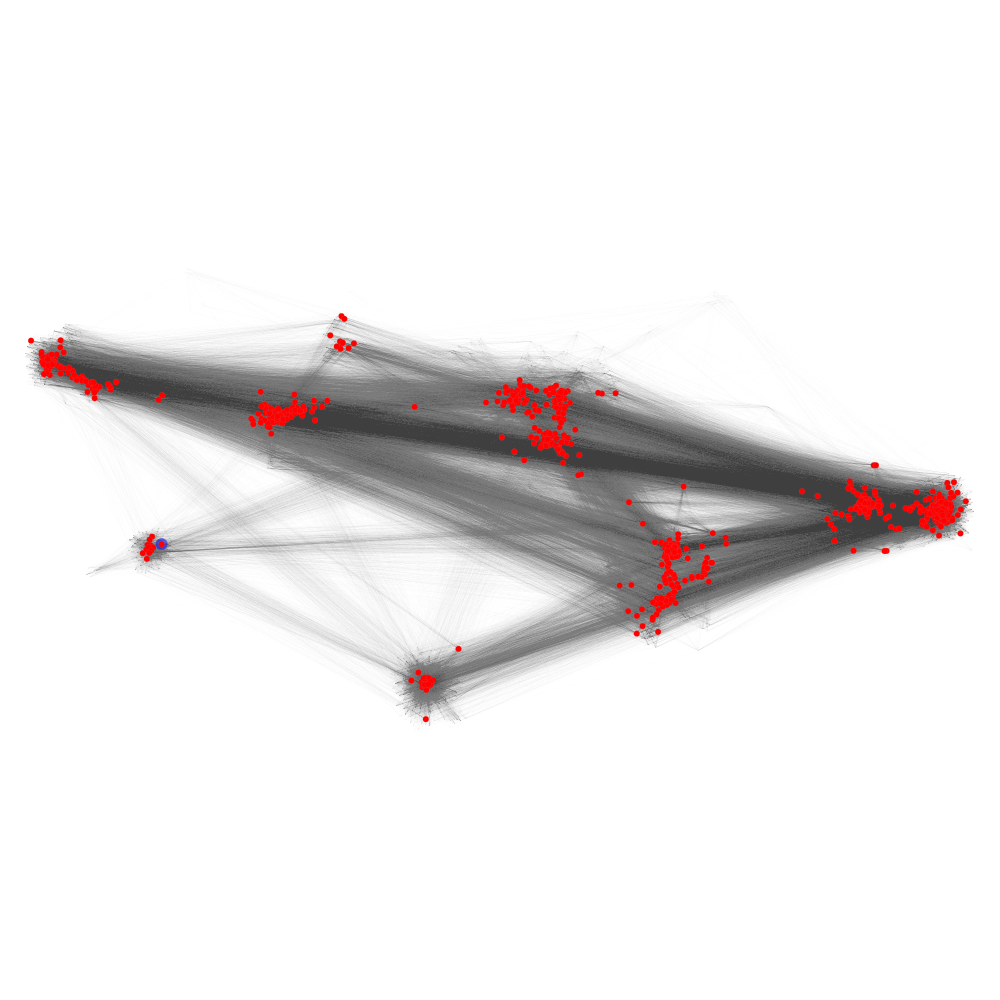

In [ ]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

alphas = [1.0e-4,1.0e-3,1.0e-2,1.0e-1,2.0e-1,3.0e-1,5.0e-1,8.0e-1,8.5e-1,9.0e-1,9.5e-1,9.9e-1]

for alpha in alphas:
    
    # Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
    # This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
    output_l1reg_fast = l1reg_fast.produce([g],[ref_node],alpha = alpha)

    # Only one input graph is given, i.e., [g]. 
    # Extract the array from position 0 and store it.
    l1_reg_vector = output_l1reg_fast[0]
    
    # Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
    output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)
    
    # Extract the partition for g and store it.
    l1_reg_vector_rounded = output_sc_fast[0][0]

    # Measure accuracy
    true_positives = set(majorIndex_217_students).intersection(l1_reg_vector_rounded)
    if len(true_positives) == 0:
        true_positives = set(ref_node)
        vol = g.d[ref_node]
    else:
        vol = sum(g.d[l1_reg_vector_rounded])   
    precision_ex = sum(g.d[np.array(list(true_positives))])/vol
    recall_ex = sum(g.d[np.array(list(true_positives))])/sum(g.d[majorIndex_217_students])
    print("Teleportation parameter: ", alpha)   
    print("precision:", precision_ex)
    print("recall: ", recall_ex)    
    
    # Visualize local partition
    temp = np.zeros(g._num_vertices) + 0.00001

    temp[l1_reg_vector_rounded] = 6

    node_size = g_gtool.new_vertex_property("double",temp)

    temp = ["black" for x in range(g._num_vertices)]

    for i in l1_reg_vector_rounded:
        temp[i] = "red"

    node_colours = g_gtool.new_vertex_property("string",temp)

    halo = np.zeros(g._num_vertices, dtype=bool)
    halo[ref_node] = True
    node_halo = g_gtool.new_vertex_property("bool",halo)

    c_map = plt.get_cmap('autumn') 
    
    graph_draw(g_gtool, pos, output_size=(1000, 1000),
               vertex_size=node_size, 
               vertex_fill_color=node_colours, 
               vertex_halo=node_halo,
               vertex_halo_size = 2.0,
               vorder=node_size,
               edge_pen_width=0.1,
               edge_color = [0.0, 0, 0, 0.05],
               vcmap=c_map)